### Edgar Moises Hernandez-Gonzalez
#### 26/02/20
#### Clasificacion de imagenes motoras en EEG con CNN-1D
##### Caracteristicas = RAW
##### 2 canales C3 y C4
##### 5 ejecuciones independientes

##### Sujeto 1
##### Accuracy = 42.01%
##### Kappa = 0.2269

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [ ]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#convertir de 2D a 3D
x_train = x_train.reshape((n_samples_train, 2, 1000))
x_test = x_test.reshape((n_samples_test, 2, 1000))

print(x_train.shape)
print(x_test.shape)

(288, 2, 1000)
(288, 2, 1000)


In [ ]:
x_train = np.transpose(x_train, (0,2,1))
x_test = np.transpose(x_test, (0,2,1))

print(x_train.shape)
print(x_test.shape)

(288, 1000, 2)
(288, 1000, 2)


In [ ]:
def CNN_1D():
  model = Sequential()
  model.add(Conv1D(64, 3, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool1D(2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  
  optimizer = Adam(lr=1e-3)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Iteration: 1
288/288 - 0s - loss: 3.9133 - acc: 0.4132
kappa:  0.21759259259259256
f1: 0.41258000081529494
confusion matrix:
 [[26 22 13 11]
 [26 28 11  7]
 [ 8  7 32 25]
 [ 4  7 28 33]]


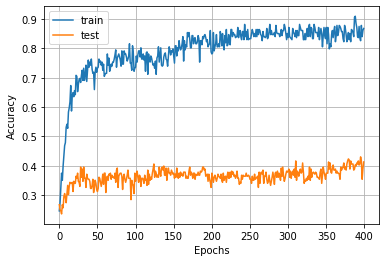

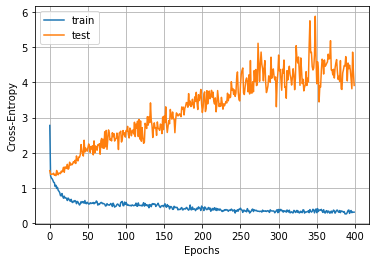

Iteration: 2
288/288 - 0s - loss: 6.3094 - acc: 0.3229
kappa:  0.09722222222222221
f1: 0.3203121856847323
confusion matrix:
 [[27 16 27  2]
 [32 17 17  6]
 [18  8 30 16]
 [15  9 29 19]]


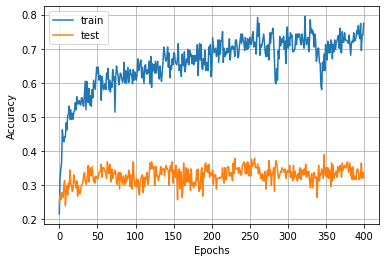

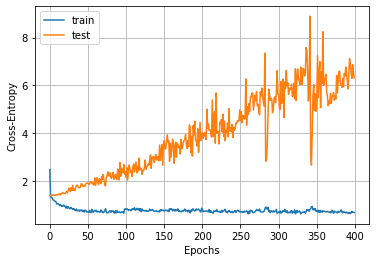


Resultados:
loss: [3.9132517443762884, 6.309438440534803]
accuracy: [0.41319445, 0.32291666]
kappa: [0.21759259259259256, 0.09722222222222221]
f1: [0.41258000081529494, 0.3203121856847323]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
array_f1 = []
for i in range(2):
    print("Iteration:", i+1);
    
    model = CNN_1D()

    history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                        validation_data=(x_test, y_test), verbose=0)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    array_loss.append(test_loss)
    array_acc.append(test_acc)
    
    probabilidades = model.predict(x_test)
    y_pred = np.argmax(probabilidades, 1) #1=fila
    
    kappa = cohen_kappa_score(y_test, y_pred)
    array_kappa.append(kappa)
    print("kappa: ", kappa)

    f1 = f1_score(y_test, y_pred, average='macro')
    array_f1.append(f1)
    print("f1:", f1)
    
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("confusion matrix:\n", matriz_confusion)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(['train', 'test'])
    plt.show()
    
print()    
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("f1:", array_f1)

In [ ]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 1000, 64)          448       
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 500, 64)           0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                2048064   
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 260       
Total params: 2,048,772
Trainable params: 2,048,772
Non-trainable params: 0
___________________________________________

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("Mean F1: %.4f" % np.mean(array_f1))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max F1: %.4f" % np.max(array_f1))

Mean Accuracy: 0.3681
Mean Kappa: 0.1574
Mean F1: 0.3664
Max Accuracy: 0.4132
Max Kappa: 0.2176
Max F1: 0.4126
